## Imports & Constants

In [1]:
import datetime
import gtab
import matplotlib.pyplot as plt
import math
import numpy as np
import pandas as pd
import pickle
import os
import seaborn as sns
import statsmodels.formula.api as smf

from utils.query_google import TrendsQueryer
from utils.plot_split_timeseries import split_timeseries_figures

In [2]:
PRISM_DATE = datetime.datetime(2013, 6, 6)

# GTAB information
TIMEFRAME = '2011-01-01 2015-12-31'

GOOGLE_DATA = 'data/GoogleTrends'
WIKI_DATA = 'data/Wikipedia'

## Data Loading / Wrangling

### Load or Query Google
Using our prepared utility functions to query relevant keywords from google trends, using the dlabs GTAB library.

In [3]:
gt = TrendsQueryer(TIMEFRAME)
gt_terror = gt.load_or_query('terror_en')
gt_domestic = gt.load_or_query('domestic_en')

Directory already exists, loading data from it.
Using directory '/home/jonathan/Projects/AppliedDataAnalysis/ada-2020-project-milestone-p3-p3_0x414441/gtab/'
Active anchorbank changed to: google_anchorbank_geo=_timeframe=2019-01-01 2020-08-01.tsv

Active anchorbank changed to: google_anchorbank_geo=_timeframe=2011-01-01 2015-12-31.tsv

Loaded terror_en.csv
Loaded domestic_en.csv


In [4]:
gt_terror.sample(frac=1).head()

,article,date,max_ratio,max_ratio_hi,max_ratio_lo,language
7230,Liberation Front,2014-07-06,0.057971,0.065693,0.050360,en
2885,Conventional Weapon,2011-04-10,0.007951,0.009267,0.006713,en
3537,Eco-Terrorism,2013-10-06,0.000000,0.000203,0.000000,en
3422,Eco-Terrorism,2011-07-24,0.000000,0.000203,0.000000,en
1927,Ammonium nitrate,2012-12-02,0.280000,0.285000,0.275000,en


#### Concatenate the dataframes to one:

In [5]:
# Concatenate the dataframes into one
gt_terror['topic'] = 'terror'
gt_domestic['topic'] = 'domestic'
google = pd.concat([gt_terror, gt_domestic])
# Create a column that simplifies the month and only leaves the month
google['date'] = pd.to_datetime(google['date'])
google['month'] = google.date.dt.to_period('M')

### Wikipedia

In [6]:
# We load the csvs of the terrorism and domestic security groups, and combine them in a single df
df_terrorism = pd.read_csv(os.path.join(WIKI_DATA, 'wiki_terrorism.csv'))
df_domestic = pd.read_csv(os.path.join(WIKI_DATA, 'wiki_domestic.csv'))

df = pd.concat([df_terrorism, df_domestic])
df.sample(frac=1).head(5)

,language,article,date,views
173213,en,islamist,2014-05-08,182
61734,en,chemical_weapon,2019-01-31,407
38571,en,eco-terrorism,2015-08-14,152
62310,en,federal_air_marshal_service,2010-09-24,415
6817,en,terrorism,2018-09-01,2029


In [7]:
# We create a mapping from article to group
group = dict()
for article in df_terrorism['article'].unique(): group[article] = 'terrorism'
for article in df_domestic['article'].unique(): group[article] = 'domestic'

In [8]:
# We then extract the month, year, time (number of months elapsed since the beginning of the period)
df['month'] = pd.DatetimeIndex(df.date).month
df['year'] = pd.DatetimeIndex(df.date).year
df['time'] = (df.year - df.year.min()) * 12 + df.month

In [9]:
# We compute the monthly total pageviews of each article
monthly_views = df.groupby(['article', 'time'])['views'].sum().reset_index().pivot_table(index='article', columns='time', values='views')
terrorism_views = monthly_views.loc[monthly_views.index.map(lambda art: group[art] == 'terrorism')]
domestic_views = monthly_views.loc[monthly_views.index.map(lambda art: group[art] == 'domestic')]

## Exploring the Wikipedia Data

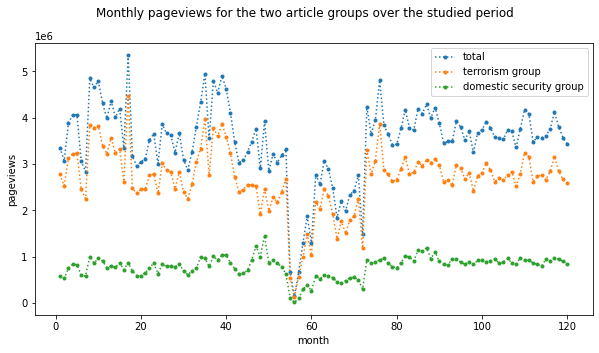

In [10]:
fig = plt.figure(figsize=(10, 5))

ax = monthly_views.sum().plot(fig=fig, style='.:', label='total')
terrorism_views.sum().plot(fig=fig, style='.:', label='terrorism group')
domestic_views.sum().plot(fig=fig, style='.:', label='domestic security group')

ax.set_xlabel('month')
ax.set_ylabel('pageviews')
plt.legend()
fig.suptitle('Monthly pageviews for the two article groups over the studied period');

We can see a strange drop of pageviews around month 55 (July 2014), let's try to understand it.

In [11]:
# We count the number of zeros for each article for each month
df['zeros'] = (df['views'] == 0).astype(int)
zeroes = df.groupby(['article', 'time'])['zeros'].mean().reset_index().pivot_table(index='article', columns='time', values='zeros')

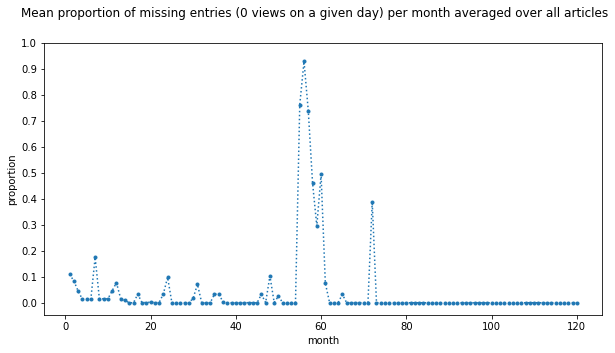

In [12]:
fig = plt.figure(figsize=(10, 5))

ax = zeroes.mean().plot(fig=fig, style='.:')

ax.set_xlabel('month')
ax.set_ylabel('proportion')
ax.set_yticks([i / 10 for i in range(11)])
fig.suptitle('Mean proportion of missing entries (0 views on a given day) per month averaged over all articles');

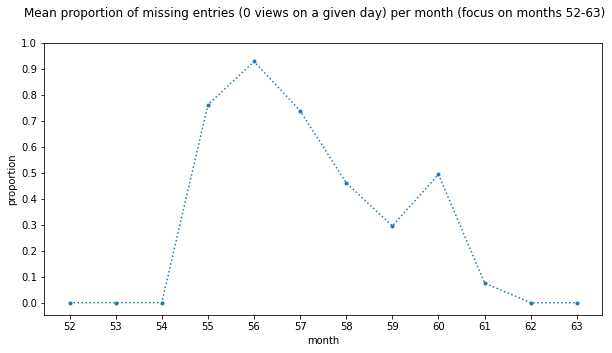

In [13]:
fig = plt.figure(figsize=(10, 5))

ax = zeroes.mean().loc[52:63].plot(fig=fig, style='.:')

ax.set_xlabel('month')
ax.set_xticks(range(52, 63+1))
ax.set_ylabel('proportion')
ax.set_yticks([i / 10 for i in range(11)])
fig.suptitle('Mean proportion of missing entries (0 views on a given day) per month (focus on months 52-63)');

This sudden increase in missing entries might be due to a Wikipedia outage during the months 54 to 60 (June to December 2014).

In any case, we will not consider these months during our analysis as this would surely affect the results. To do so, in the regression we will simply drop the entries corresponding to the mentioned months, without shifting the month numbers after them.

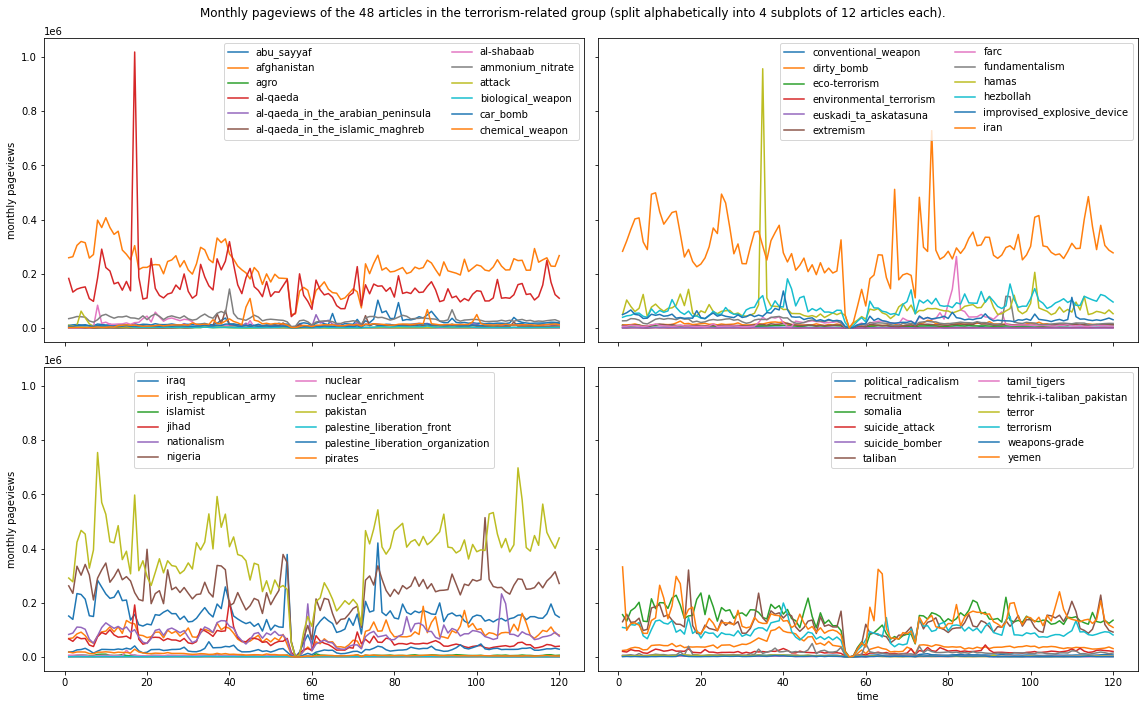

In [14]:
fig, axes = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=(16, 10))

terrorism_views.T.iloc[:,  0: 12].plot(ax=axes[0, 0])
terrorism_views.T.iloc[:, 12: 24].plot(ax=axes[0, 1])
terrorism_views.T.iloc[:, 24: 36].plot(ax=axes[1, 0])
terrorism_views.T.iloc[:, 36: 48].plot(ax=axes[1, 1])

axes[0, 0].set_ylabel('monthly pageviews')
axes[1, 0].set_ylabel('monthly pageviews')

axes[0, 0].legend(ncol=2)
axes[1, 0].legend(ncol=2)
axes[0, 1].legend(ncol=2)
axes[1, 1].legend(ncol=2)

fig.suptitle('Monthly pageviews of the 48 articles in the terrorism-related group'
             ' (split alphabetically into 4 subplots of 12 articles each).')

fig.set_tight_layout(True)

As we can see, there is a spike of pageviews for `al-qaeda` on around month 17 (May 2011, when Al-Qaeda's emir Osama bin Laden was killed), and for `hamas` around month 34 (October 2012, during the Operation "Pillar of Defense" conflict).

Since these mediatized events are expected to increase the number of pageviews, and have little to do with chilling effects, we will not consider them in our analysis.

In [15]:
terrorism_clean = terrorism_views.drop(['hamas', 'al-qaeda'])

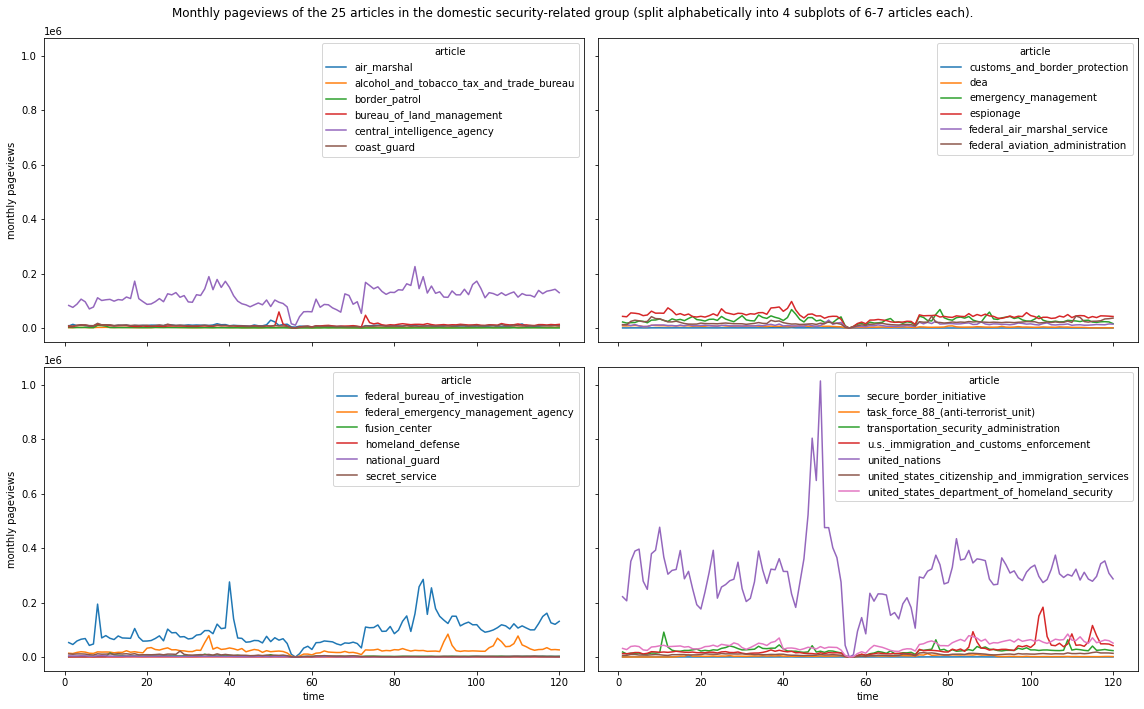

In [16]:
fig, axes = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=(16, 10))

domestic_views.T.iloc[:,  0:  6].plot(ax=axes[0, 0])
domestic_views.T.iloc[:,  6: 12].plot(ax=axes[0, 1])
domestic_views.T.iloc[:, 12: 18].plot(ax=axes[1, 0])
domestic_views.T.iloc[:, 18: 25].plot(ax=axes[1, 1])

axes[0, 0].set_ylabel('monthly pageviews')
axes[1, 0].set_ylabel('monthly pageviews')


fig.suptitle('Monthly pageviews of the 25 articles in the domestic security-related group'
             ' (split alphabetically into 4 subplots of 6-7 articles each).')

fig.set_tight_layout(True)

We can see that `united_nations` has considerably more views than the other topics, with a spike around month 50 (February 2014, we can't explain it). We will not consider this article for our analysis to remove oscillations due only to it.

In [17]:
domestic_clean = domestic_views.drop('united_nations')

## Exploring the Google Trends Data

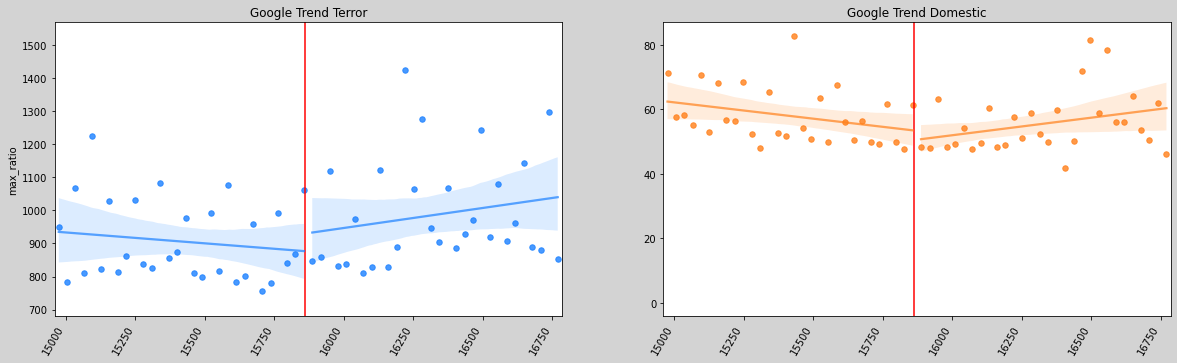

In [18]:
monthly_interest = google.groupby(['article', 'month', 'topic']).sum().reset_index().set_index('month')
terror = monthly_interest.loc[monthly_interest.topic == 'terror'].groupby('month').sum()
domestic = monthly_interest.loc[monthly_interest.topic == 'domestic'].groupby('month').sum()
split_timeseries_figures([terror, domestic],
                        names=['Google Trend Terror', 'Google Trend Domestic'],
                        keyword='max_ratio',
                        figsize=[20, 6],
                        same_plot=False,
                        sharey=False,
                        colors={'Google Trend Terror': [0.1, 0.5, 1, 0.7],
                               'Google Trend Domestic': [1, 0.5, 0.1, 0.7]})

The first impression is, there are no extreme outliers in the queried data when cumulated, but better let's have a look at the single articles. Note that, in the following plot, for the sake of an easier outlier detection, the plot are not on equal scale:

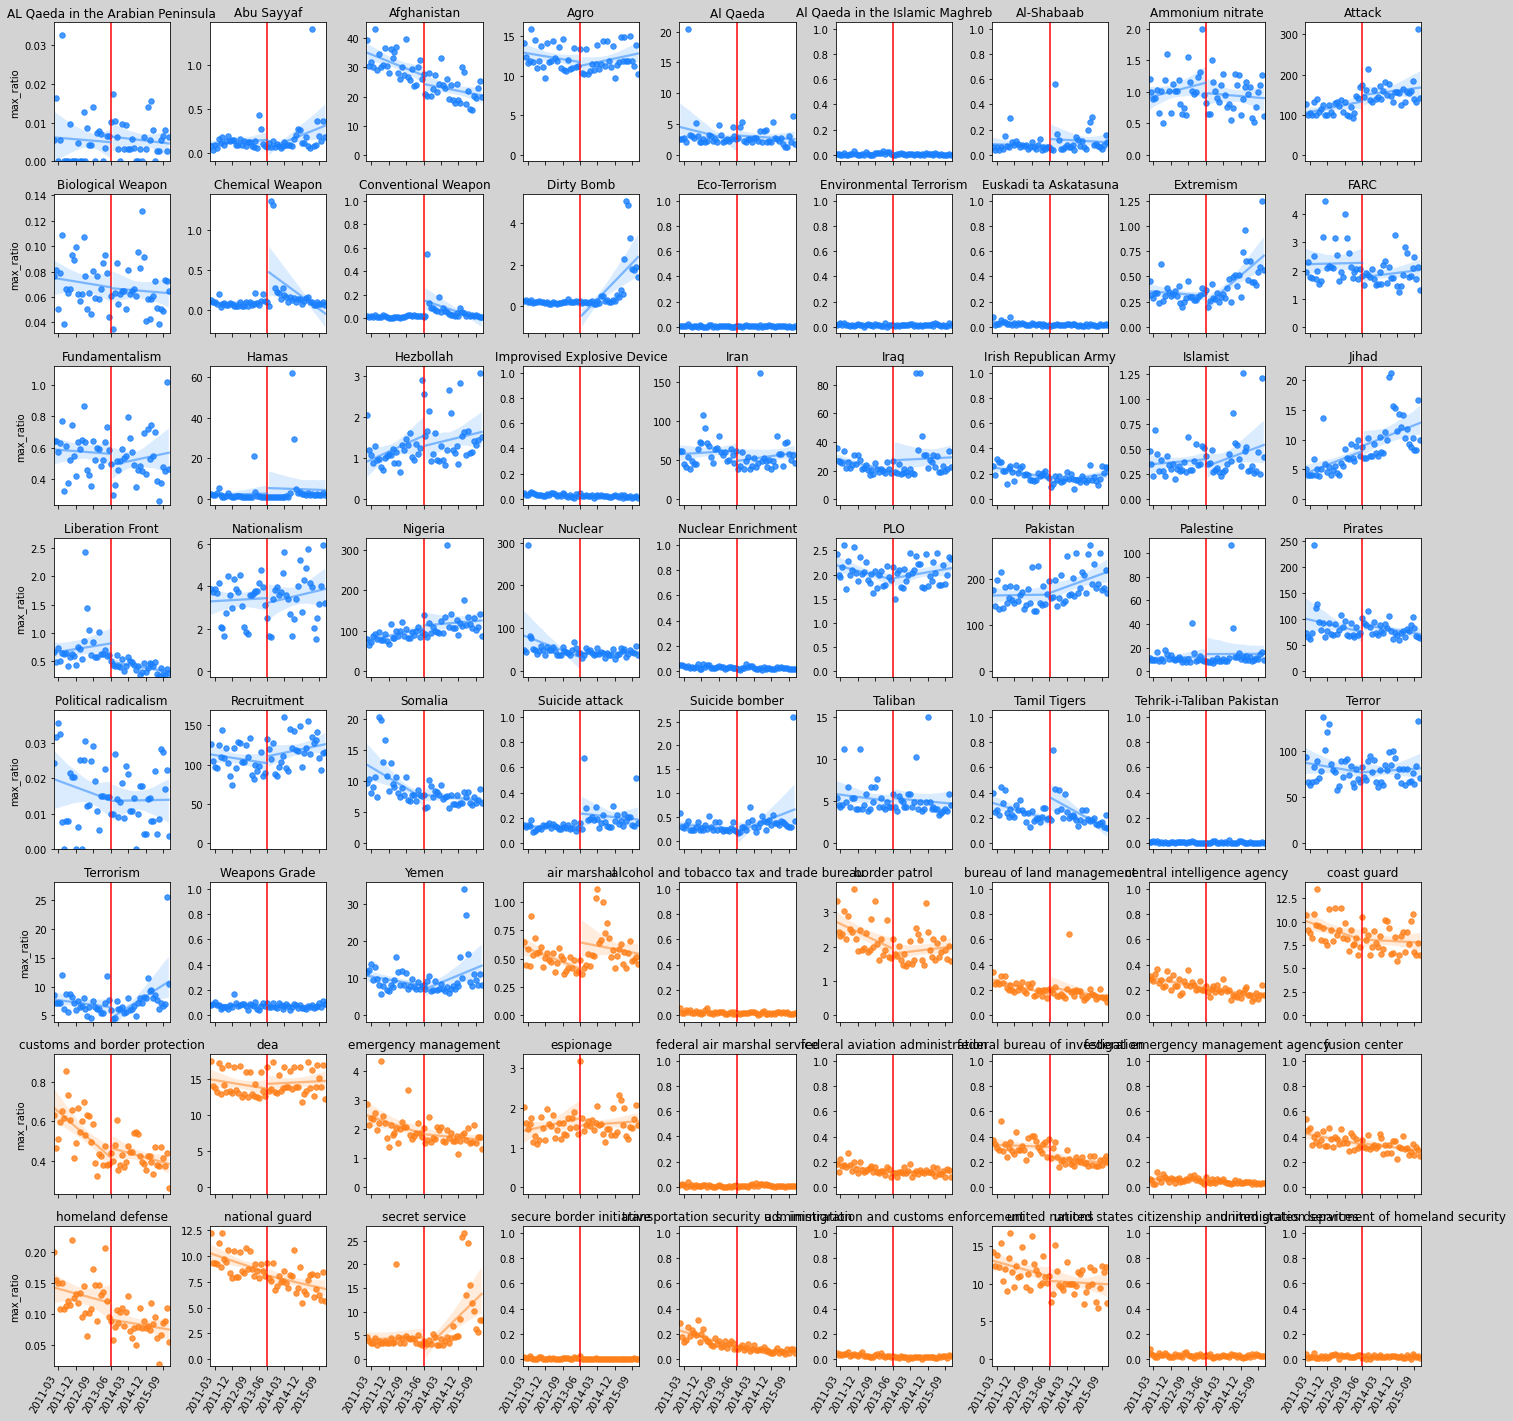

In [19]:
colors = {name: [0.1, 0.5, 1, 0.5] for name in monthly_interest.loc[monthly_interest.topic == 'terror'].article.unique()}
colors.update({name: [1, 0.5, 0.1, 0.5] for name in monthly_interest.loc[monthly_interest.topic == 'domestic'].article.unique()})
split_timeseries_figures(in_frames=[monthly_interest.loc[monthly_interest.article == article] for article in monthly_interest.article.unique()],
                         names=monthly_interest.article.unique(),
                         keyword='max_ratio',
                         same_plot=False,
                         legend=False,
                         figsize=[20, 20],
                         log=True,
                         sharey=False,
                         colors=colors)
plt.tight_layout()

## Regression

In [20]:
# DataFrame to apply the ITS analysis to
its = pd.DataFrame()

# Monthly number of views aggregated over the 46 terrorism articles
its['terrorism_views'] = terrorism_clean.sum()
# Monthly number of views aggregated over the 24 domestic articles
its['domestic_views'] = domestic_clean.sum()

# Indicator of whether the NSA revelations have already happened (month 42 is June 2013)
its['NSA'] = (its.index.to_series() >= 42).astype(int)
# We just do this to be able to use the column 'month' in the regression
its['month'] = its.index
its.head(3)

,terrorism_views,domestic_views,NSA,month
time,,,,
1,2543555,357822,0,1
2,2300062,329104,0,2
3,2902618,407211,0,3


In [21]:
terrorism_regr = smf.ols(formula='terrorism_views ~ month * NSA', data=its.drop(range(54, 60+1))).fit()
print(terrorism_regr.summary())
its['terrorism_regr'] = terrorism_regr.predict(its)
its[['terrorism_lower', 'terrorism_upper']] = terrorism_regr.get_prediction(its).summary_frame(alpha=0.05).iloc[:, 2:4].values

                            OLS Regression Results                            
Dep. Variable:        terrorism_views   R-squared:                       0.246
Model:                            OLS   Adj. R-squared:                  0.225
Method:                 Least Squares   F-statistic:                     11.85
Date:                Thu, 10 Dec 2020   Prob (F-statistic):           8.93e-07
Time:                        17:26:12   Log-Likelihood:                -1621.5
No. Observations:                 113   AIC:                             3251.
Df Residuals:                     109   BIC:                             3262.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   2.744e+06   1.34e+05     20.526      0.0

In [22]:
domestic_regr = smf.ols(formula='domestic_views ~ month * NSA', data=its.drop(range(54, 60+1))).fit()
print(domestic_regr.summary())
its['domestic_regr'] = domestic_regr.predict(its)
its[['domestic_lower', 'domestic_upper']] = domestic_regr.get_prediction(its).summary_frame(alpha=0.05).iloc[:, 2:4].values

                            OLS Regression Results                            
Dep. Variable:         domestic_views   R-squared:                       0.411
Model:                            OLS   Adj. R-squared:                  0.395
Method:                 Least Squares   F-statistic:                     25.39
Date:                Thu, 10 Dec 2020   Prob (F-statistic):           1.56e-12
Time:                        17:26:12   Log-Likelihood:                -1450.8
No. Observations:                 113   AIC:                             2910.
Df Residuals:                     109   BIC:                             2921.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   3.819e+05   2.95e+04     12.935      0.0

In [23]:
its

,terrorism_views,domestic_views,NSA,month,terrorism_regr,terrorism_lower,terrorism_upper,domestic_regr,domestic_lower,domestic_upper
time,,,,,,,,,,
1,2543555,357822,0,1,2.745027e+06,2.489591e+06,3.000464e+06,387132.024390,330716.367329,443547.681452
2,2300062,329104,0,2,2.746041e+06,2.500002e+06,2.992081e+06,392350.496341,338010.246148,446690.746535
3,2902618,407211,0,3,2.747056e+06,2.510276e+06,2.983836e+06,397568.968293,345273.776392,449864.160194
4,3016457,453161,0,4,2.748070e+06,2.520395e+06,2.975744e+06,402787.440244,352503.255094,453071.625394
5,3009786,431957,0,5,2.749084e+06,2.530341e+06,2.967827e+06,408005.912195,359694.429793,456317.394597
...,...,...,...,...,...,...,...,...,...,...
116,2627241,615685,1,116,2.710313e+06,2.537573e+06,2.883052e+06,641979.504564,603828.387767,680130.621361
117,2854994,623244,1,117,2.719408e+06,2.543071e+06,2.895745e+06,645563.582510,606617.773443,684509.391577
118,2628558,599062,1,118,2.728504e+06,2.548535e+06,2.908472e+06,649147.660456,609399.809429,688895.511482


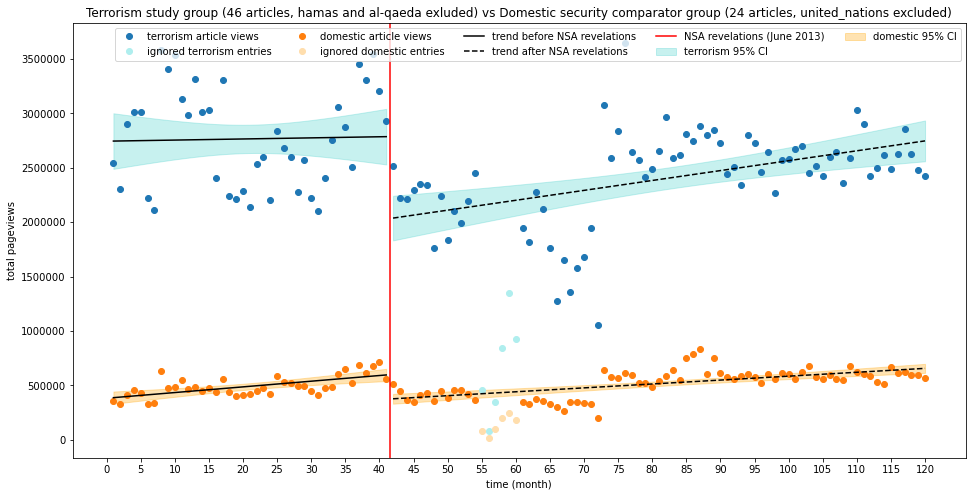

In [25]:
plt.figure(figsize=(16, 8))
plt.ticklabel_format(axis='y', style='plain')

# Plot the actual monthly pageviews as dots
plt.plot(its['terrorism_views'].drop(range(55, 60+1)), 'o', label='terrorism article views')
plt.plot(its['terrorism_views'].loc[55:60], 'o', color='paleturquoise', label='ignored terrorism entries')

# Plot the actual monthly pageviews as dots
plt.plot(its['domestic_views'].drop(range(55, 60+1)), 'o', label='domestic article views')
plt.plot(its['domestic_views'].loc[55:60], 'o', color='navajowhite', label='ignored domestic entries')

# Plot the regression line before the June 2013 revelations (June 2013 excluded)
plt.plot(its.loc[:41, 'terrorism_regr'], 'k-', label='trend before NSA revelations')
# Plot the regression line after the June 2013 revelations (June 2013 included)
plt.plot(its.loc[42:, 'terrorism_regr'], 'k--', label='trend after NSA revelations')

# Plot the regression line before the June 2013 revelations (June 2013 excluded)
plt.plot(its.loc[:41, 'domestic_regr'], 'k-')
# Plot the regression line after the June 2013 revelations (June 2013 included)
plt.plot(its.loc[42:, 'domestic_regr'], 'k--')

# Plot the regression confidence intervals
plt.fill_between(its.loc[:41].index, its.loc[:41]['terrorism_lower'], its.loc[:41]['terrorism_upper'],
                 alpha=0.3, color='mediumturquoise', label='terrorism 95% CI')
plt.fill_between(its.loc[42:].index, its.loc[42:]['terrorism_lower'], its.loc[42:]['terrorism_upper'],
                 alpha=0.3, color='mediumturquoise')

plt.fill_between(its.loc[:41].index, its.loc[:41]['domestic_lower'], its.loc[:41]['domestic_upper'],
                 alpha=0.3, color='orange', label='domestic 95% CI')
plt.fill_between(its.loc[42:].index, its.loc[42:]['domestic_lower'], its.loc[42:]['domestic_upper'],
                 alpha=0.3, color='orange')

# Show the moment of the NSA revelations
plt.axvline(x=41.5, color='r', label='NSA revelations (June 2013)')

# Show legend, set title, axis labels, x ticks
plt.legend(ncol=5)
plt.title('Terrorism study group (46 articles, hamas and al-qaeda exluded)'
          ' vs Domestic security comparator group (24 articles, united_nations excluded)')
plt.xlabel('time (month)')
plt.xticks(range(0, 120+1, 5))
plt.ylabel('total pageviews');